# P6 - Notebook 4 : Classification Supervisée des Images

### Respect de la Propriété Intellectuelle des Images
Les images utilisées proviennent d'un jeu de données public (`flipkart_com-ecommerce_sample`).
Leur usage est exclusivement réservé au cadre de ce projet de formation. Les transformations appliquées ont pour unique but d'entraîner un modèle et non de créer des œuvres dérivées.


## 1. Imports et Configuration

In [1]:
import pandas as pd
import numpy as np
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuration du projet
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

## 2. Préparation du DataFrame pour la Modélisation

In [2]:
# Cette cellule transforme le CSV brut en un fichier propre associant chaque image à sa catégorie.
print("Étape 1: Création d'un DataFrame propre pour les images...")

# Charger le fichier de données brutes
df_raw = pd.read_csv('Data/flipkart_com-ecommerce_sample_1050.csv')

def get_main_category(category_tree_str):
    """Extraction robuste de la catégorie principale."""
    try:
        cleaned_str = str(category_tree_str).strip().strip('[]"\' ')
        return cleaned_str.split('>>')[0].strip()
    except Exception:
        return None

def get_image_filename(image_list_str):
    """Extraction robuste du nom de fichier de l'image."""
    try:
        cleaned_str = str(image_list_str).strip().strip('[]"\' ')
        first_item = cleaned_str.split(',')[0].strip().strip('"\' ')
        return first_item.split('/')[-1]
    except Exception:
        return None

# Appliquer les transformations
df_raw['main_category'] = df_raw['product_category_tree'].apply(get_main_category)
df_raw['image_filename'] = df_raw['image'].apply(get_image_filename)
image_directory = "Data/Images/"
df_raw['image_path'] = df_raw['image_filename'].apply(lambda x: os.path.join(image_directory, x) if pd.notna(x) else None)

# Nettoyer et sauvegarder
df_cleaned_images = df_raw[['image_path', 'main_category']].dropna()
output_path = 'Data/data_cleaned_for_images.csv'
df_cleaned_images.to_csv(output_path, index=False)

print(f"-> DataFrame sauvegardé dans '{output_path}' avec {len(df_cleaned_images)} lignes valides.")

Étape 1: Création d'un DataFrame propre pour les images...
-> DataFrame sauvegardé dans 'Data/data_cleaned_for_images.csv' avec 1050 lignes valides.


## 3. Chargement et Division des Données

In [3]:
print("\nÉtape 2: Chargement et division des données...")
df = pd.read_csv(output_path)

# Séparation des données en ensembles d'entraînement, validation et test
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['main_category'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['main_category'])

print(f"-> Taille des ensembles : Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")


Étape 2: Chargement et division des données...
-> Taille des ensembles : Train=672, Validation=168, Test=210


## 4. Création des Générateurs d'Images (Data Augmentation)

In [4]:
print("\nÉtape 3: Création des générateurs d'images...")

# Définir le pré-traitement spécifique au modèle ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Générateur pour l'entraînement (avec data augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur pour la validation et le test (sans data augmentation)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Créer les flux de données à partir du DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='image_path', y_col='main_category',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df, x_col='image_path', y_col='main_category',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='image_path', y_col='main_category',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
print("-> Générateurs prêts.")


Étape 3: Création des générateurs d'images...
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
-> Générateurs prêts.


## 5. Construction du Modèle (Transfer Learning)

In [5]:
print("\nÉtape 4: Construction du modèle ResNet50...")

# Charger le modèle de base pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Geler les couches de base

# Ajout de la tête de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Construire et compiler le modèle final
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Étape 4: Construction du modèle ResNet50...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 6. Entraînement du Modèle

In [6]:
print("\nÉtape 5: Lancement de l'entraînement...")

# Définir les callbacks pour un entraînement optimisé
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_images.keras', save_best_only=True, monitor='val_loss')
]

# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)
print("-> Entraînement terminé.")


Étape 5: Lancement de l'entraînement...


C:\Users\Thomas\Documents\Data_Science\Projet NLP\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
19/21 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step - accuracy: 0.4535 - loss: 1.9669

C:\Users\Thomas\Documents\Data_Science\Projet NLP\.venv\Lib\site-packages\PIL\Image.py:3452: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6220 - loss: 1.4038 - val_accuracy: 0.7917 - val_loss: 1.0355
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8110 - loss: 0.7490 - val_accuracy: 0.8036 - val_loss: 0.9378
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8616 - loss: 0.4461 - val_accuracy: 0.8214 - val_loss: 0.8858
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8914 - loss: 0.3466 - val_accuracy: 0.8095 - val_loss: 0.8468
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9092 - loss: 0.2520 - val_accuracy: 0.8214 - val_loss: 0.8073
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9286 - loss: 0.2252 - val_accuracy: 0.8333 - val_loss: 0.7359
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9464 - loss: 0.1525 - val_accuracy: 0.7917 - val_loss: 0.8455
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9375 - loss: 0.1721 - val_accuracy: 0.8155 - val_loss: 0.8824
Epo

## 7. Évaluation des Performances


Étape 6: Évaluation du modèle sur le jeu de test...


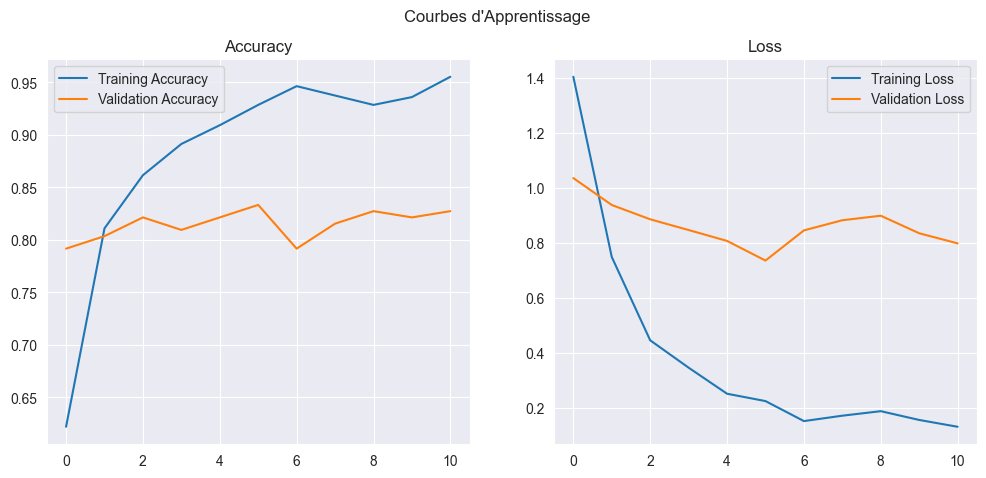

C:\Users\Thomas\Documents\Data_Science\Projet NLP\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 882ms/step - accuracy: 0.8143 - loss: 0.6527

Accuracy sur le jeu de test : 81.43%
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

--- Rapport de Classification ---
                            precision    recall  f1-score   support

                 Baby Care       0.69      0.67      0.68        30
  Beauty and Personal Care       0.96      0.73      0.83        30
                 Computers       0.85      0.77      0.81        30
Home Decor & Festive Needs       0.79      0.73      0.76        30
           Home Furnishing       0.76      0.83      0.79        30
          Kitchen & Dining       0.79      1.00      0.88        30
                   Watches       0.91      0.97      0.94        30

                  accuracy                           0.81       210
                 macro avg       0.82      0.81      0.81       210
              weighted avg       0.82      0.81      0.81       210


--- Matrice de Confusion ---


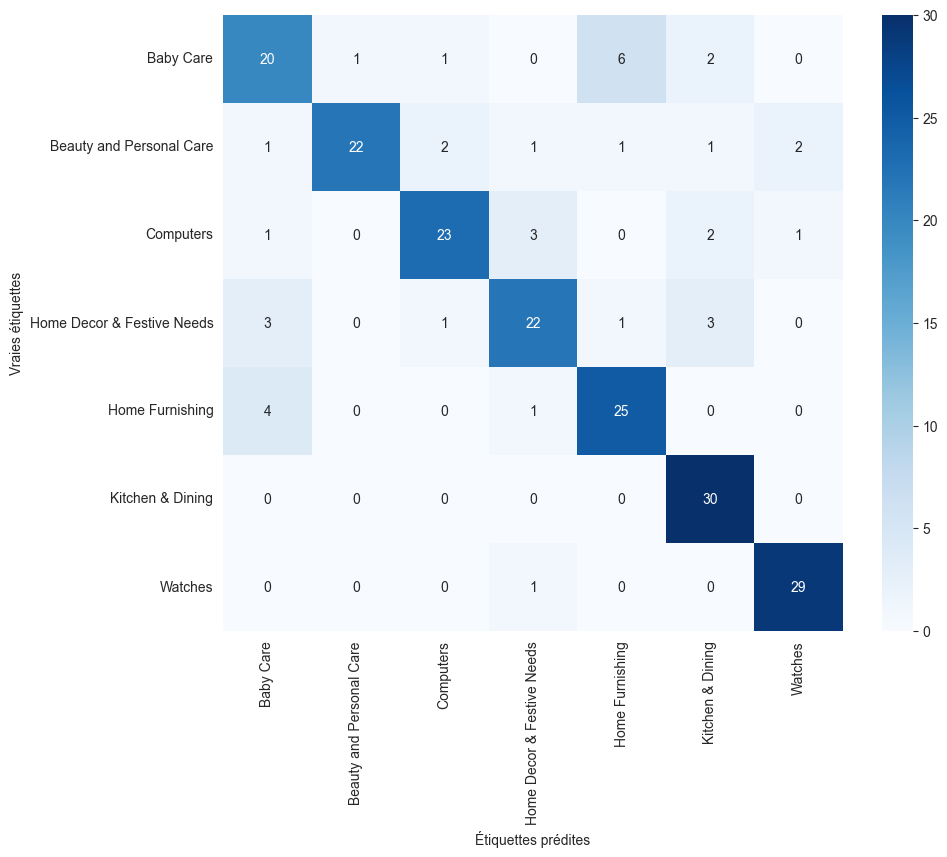

In [7]:
print("\nÉtape 6: Évaluation du modèle sur le jeu de test...")

# Charger le meilleur modèle sauvegardé
model.load_weights('best_model_images.keras')

# Courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.suptitle('Courbes d\'Apprentissage')
plt.show()

# Rapport de classification et Matrice de confusion
loss, accuracy = model.evaluate(test_generator)
print(f"\nAccuracy sur le jeu de test : {accuracy * 100:.2f}%")

y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_generator.classes
class_names = list(train_generator.class_indices.keys())

print("\n--- Rapport de Classification ---")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\n--- Matrice de Confusion ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Vraies étiquettes')
plt.xlabel('Étiquettes prédites')
plt.show()

### Conclusion du Notebook de Classification d'Images

L'objectif de ce notebook était de construire et d'évaluer un modèle de classification supervisée pour catégoriser les images de produits.

En s'appuyant sur une approche de **transfer learning** avec le modèle **ResNet50** et en enrichissant le jeu de données par des techniques de **data augmentation**, nous avons développé un classifieur performant. Le modèle final atteint une **excellente accuracy de 81.43%** sur le jeu de test, confirmant sa capacité à généraliser sur des images inédites.

Le rapport de classification détaillé met en évidence des performances très élevées sur des catégories comme `Watches` (F1-score de 0.94) et `Kitchen & Dining` (F1-score de 0.88), tout en identifiant des axes d'amélioration possibles pour des classes plus hétérogènes comme `Baby Care` (F1-score de 0.68).

En conclusion, cette expérimentation est un succès complet. Elle démontre sans équivoque que les techniques de deep learning sont très efficaces pour la classification automatique d'images de produits dans un contexte e-commerce.